* If you're running this on Google Colab, please uncomment and run the cell below.

In [41]:
%matplotlib inline
import matplotlib.pyplot as plt
from tqdm import trange

import time

import torch
import torch.nn as nn
import torch.optim as optim
from IPython import display


## 1. SPINN

In [34]:
class SPINN(nn.Module):
    def __init__(self, features):
        super().__init__()
        self.features = features
        
        # Создаем слои для каждого входа (t, x, y)
        self.networks = nn.ModuleList([
            self._build_network() for _ in range(3)
        ])
        
        # Добавляем слои для объединения выходов
        self.combine_layer1 = nn.Linear(features[-1] * 2, features[-1])
        self.combine_layer2 = nn.Linear(features[-1] * 2, features[-1])
        self.final_layer = nn.Linear(features[-1], 1)
        self.activation = nn.Tanh()
    
    def _build_network(self):
        layers = []
        layers.append(nn.Linear(1, self.features[0]))
        layers.append(nn.Tanh())
        
        for i in range(len(self.features) - 2):
            layers.append(nn.Linear(self.features[i], self.features[i + 1]))
            layers.append(nn.Tanh())
            
        layers.append(nn.Linear(self.features[-2], self.features[-1]))
        layers.append(nn.Tanh())
        return nn.Sequential(*layers)
    
    def _ensure_2d(self, x):
        if x.dim() == 1:
            return x.unsqueeze(1)
        return x
    
    def forward(self, t, x, y):
        # Преобразуем входы в 2D тензоры [batch_size, 1]
        t = self._ensure_2d(t)
        x = self._ensure_2d(x)
        y = self._ensure_2d(y)
        
        # Пропускаем через отдельные сети
        t_features = self.networks[0](t)
        x_features = self.networks[1](x)
        y_features = self.networks[2](y)
        
        # Объединяем признаки
        combined = torch.cat([t_features, x_features], dim=1)
        combined = self.activation(self.combine_layer1(combined))
        
        combined = torch.cat([combined, y_features], dim=1)
        combined = self.activation(self.combine_layer2(combined))
        
        # Финальный слой
        output = self.final_layer(combined)
        return output.squeeze(-1)
    
# Функция для вычисления производных второго порядка
def compute_second_derivative(u, x):
    du_dx = torch.autograd.grad(
        u.sum(), x, 
        create_graph=True,
        retain_graph=True
    )[0]
    d2u_dx2 = torch.autograd.grad(
        du_dx.sum(), x,
        create_graph=True,
        retain_graph=True
    )[0]
    return d2u_dx2

class SPINN_Loss:
    def __init__(self, model):
        self.model = model

    def residual_loss(self, t, x, y, source_term):
        t.requires_grad_(True)
        x.requires_grad_(True)
        y.requires_grad_(True)
        
        u = self.model(t, x, y)
        
        utt = compute_second_derivative(u, t)
        uxx = compute_second_derivative(u, x)
        uyy = compute_second_derivative(u, y)
        
        residual = utt - uxx - uyy + u**2 - source_term
        return torch.mean(residual**2)

    def initial_loss(self, t, x, y, u_true):
        u_pred = self.model(t, x, y)
        return torch.mean((u_pred - u_true)**2)

    def boundary_loss(self, t, x, y, u_true):
        loss = 0.
        for i in range(len(t)):
            u_pred = self.model(t[i], x[i], y[i])
            loss += torch.mean((u_pred - u_true[i])**2)
        return loss / len(t)

    def __call__(self, *train_data):
        tc, xc, yc, uc, ti, xi, yi, ui, tb, xb, yb, ub = train_data
        
        loss_residual = self.residual_loss(tc, xc, yc, uc)
        loss_initial = self.initial_loss(ti, xi, yi, ui)
        loss_boundary = self.boundary_loss(tb, xb, yb, ub)
        
        return loss_residual + loss_initial + loss_boundary


# Функция шага оптимизации
def update_model(model, optimizer, train_data):
    optimizer.zero_grad()
    loss = spinn_loss_klein_gordon3d(model, *train_data)
    loss.backward()
    optimizer.step()
    return loss.item()

## 2. Data generator

In [35]:
# Точное решение уравнения Кляйна-Гордона
def _klein_gordon3d_exact_u(t, x, y):
    return (x + y) * torch.cos(2*t) + (x * y) * torch.sin(2*t)

# Источниковый член уравнения Кляйна-Гордона
def _klein_gordon3d_source_term(t, x, y):
    u = _klein_gordon3d_exact_u(t, x, y)
    return u**2 - 4*u

# Генератор тренировочных данных
def spinn_train_generator_klein_gordon3d(nc, seed=None):
    if seed is not None:
        torch.manual_seed(seed)
    
    # Точки коллокации
    tc = torch.rand(nc) * 10.0
    xc = torch.rand(nc) * 2.0 - 1.0
    yc = torch.rand(nc) * 2.0 - 1.0
    uc = _klein_gordon3d_source_term(tc, xc, yc)
    
    # Начальные точки
    ti = torch.zeros(nc)
    xi = torch.rand(nc) * 2.0 - 1.0
    yi = torch.rand(nc) * 2.0 - 1.0
    ui = _klein_gordon3d_exact_u(ti, xi, yi)
    
    # Граничные точки
    tb = [tc] * 4
    xb = [torch.full_like(tc, -1.0),
          torch.full_like(tc, 1.0),
          xc,
          xc]
    yb = [yc,
          yc,
          torch.full_like(tc, -1.0),
          torch.full_like(tc, 1.0)]
    
    ub = [_klein_gordon3d_exact_u(tb[i], xb[i], yb[i]) for i in range(4)]
    
    return tc, xc, yc, uc, ti, xi, yi, ui, tb, xb, yb, ub

# Генератор тестовых данных
def spinn_test_generator_klein_gordon3d(nc_test):
    t = torch.linspace(0, 10, nc_test)
    x = torch.linspace(-1, 1, nc_test)
    y = torch.linspace(-1, 1, nc_test)
    
    tm, xm, ym = torch.meshgrid(t, x, y, indexing='ij')
    u_gt = _klein_gordon3d_exact_u(tm, xm, ym)
    
    return t, x, y, u_gt, tm, xm, ym


## 3. Utils

In [36]:
def relative_l2(u, u_gt):
    return torch.norm(u - u_gt) / torch.norm(u_gt)

def plot_klein_gordon3d(t, x, y, u):
    # Преобразуем тензоры PyTorch в numpy массивы для визуализации
    t = t.detach().cpu().numpy().flatten()
    x = x.detach().cpu().numpy().flatten()
    y = y.detach().cpu().numpy().flatten()
    u = u.detach().cpu().numpy().flatten()
    
    # Нормализуем значения для цветовой карты
    u_norm = (u - u.min()) / (u.max() - u.min())
    
    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111, projection='3d')
    
    # Создаем scatter plot с нормализованными цветами
    scatter = ax.scatter(t, x, y, c=u_norm, s=1, cmap='seismic', vmin=0, vmax=1)
    
    # Настраиваем внешний вид
    ax.set_title('U(t, x, y)', fontsize=20)
    ax.set_xlabel('t', fontsize=18, labelpad=10)
    ax.set_ylabel('x', fontsize=18, labelpad=10)
    ax.set_zlabel('y', fontsize=18, labelpad=10)
    
    # Добавляем colorbar с реальными значениями
    cbar = plt.colorbar(scatter)
    cbar.set_label('u(t,x,y)', fontsize=16)
    
    plt.show()
    # Сохраняем результат
    # plt.savefig('klein_gordon3d.png', dpi=300, bbox_inches='tight')
    # plt.close()

## 4. Main function

In [42]:
def main(NC, NI, NB, NC_TEST, SEED, LR, EPOCHS, N_LAYERS, FEATURES, LOG_ITER):
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    torch.manual_seed(SEED)
    
    feat_sizes = [FEATURES] * N_LAYERS
    model = SPINN(feat_sizes).to(device)
    criterion = SPINN_Loss(model)
    optimizer = optim.Adam(model.parameters(), lr=LR)
    
    # Списки для хранения значений лоссов
    loss_history = []
    residual_loss_history = []
    initial_loss_history = []
    boundary_loss_history = []
    error_history = []
    
    train_data = spinn_train_generator_klein_gordon3d(NC, seed=SEED)
    train_data = [t.to(device) if isinstance(t, torch.Tensor) else 
                 [tensor.to(device) for tensor in t] if isinstance(t, list) else t 
                 for t in train_data]
    
    # Генерируем и перемещаем тестовые данные на GPU
    t, x, y, u_gt, tm, xm, ym = spinn_test_generator_klein_gordon3d(NC_TEST)
    t = t.to(device)
    x = x.to(device)
    y = y.to(device)
    u_gt = u_gt.to(device)
    tm = tm.to(device)
    xm = xm.to(device)
    ym = ym.to(device)
    
    pbar = trange(1, EPOCHS + 1)
    best_error = float('inf')
    
    for e in pbar:
        optimizer.zero_grad()
        tc, xc, yc, uc, ti, xi, yi, ui, tb, xb, yb, ub = train_data
        
        # Вычисляем компоненты функции потерь
        loss_residual = criterion.residual_loss(tc, xc, yc, uc)
        loss_initial = criterion.initial_loss(ti, xi, yi, ui)
        loss_boundary = criterion.boundary_loss(tb, xb, yb, ub)
        
        # Общие потери
        loss = loss_residual + loss_initial + loss_boundary
        
        loss.backward()
        optimizer.step()
        
        # Сохраняем значения лоссов
        loss_history.append(loss.item())
        residual_loss_history.append(loss_residual.item())
        initial_loss_history.append(loss_initial.item())
        boundary_loss_history.append(loss_boundary.item())
        
        if e % LOG_ITER == 0:
            with torch.no_grad():
                model.eval()
                u = model(tm.reshape(-1), xm.reshape(-1), ym.reshape(-1))
                error = relative_l2(u, u_gt.reshape(-1))
                error_history.append(error.item())
                
                display.clear_output(wait=True)
                
                # Сохраняем лучший результат
                if error < best_error:
                    best_error = error
                    # Сохраняем визуализацию для лучшего результата
                    u = u.reshape(tm.shape)
                    plt.figure(figsize=(12, 4))
                    plt.subplot(121)
                    plot_klein_gordon3d(tm, xm, ym, u)
                
                # Визуализация лоссов
                plt.figure(figsize=(15, 5))
                plt.subplot(121)
                plt.semilogy(loss_history, label='Total Loss')
                plt.semilogy(residual_loss_history, label='Residual Loss')
                plt.semilogy(initial_loss_history, label='Initial Loss')
                plt.semilogy(boundary_loss_history, label='Boundary Loss')
                plt.grid(True)
                plt.legend()
                plt.xlabel('Iteration')
                plt.ylabel('Loss (log scale)')
                plt.title('Training Losses')
                
                plt.subplot(122)
                plt.semilogy(range(0, len(error_history) * LOG_ITER, LOG_ITER), error_history, 'r-', label='Relative L2 Error')
                plt.grid(True)
                plt.legend()
                plt.xlabel('Iteration')
                plt.ylabel('Error (log scale)')
                plt.title('Relative L2 Error')
                plt.tight_layout()
                plt.show()
                
                pbar.set_description(
                    f'Loss: {loss.item():.2e} '
                    f'(R: {loss_residual.item():.2e}, '
                    f'I: {loss_initial.item():.2e}, '
                    f'B: {loss_boundary.item():.2e}), '
                    f'Error: {error.item():.2e}'
                )
                model.train()
    
    print(f'\nTraining completed! Best error: {best_error:.2e}')
    
    # Финальная визуализация всех лоссов
    plt.figure(figsize=(15, 5))
    plt.subplot(121)
    plt.semilogy(loss_history, label='Total Loss')
    plt.semilogy(residual_loss_history, label='Residual Loss')
    plt.semilogy(initial_loss_history, label='Initial Loss')
    plt.semilogy(boundary_loss_history, label='Boundary Loss')
    plt.grid(True)
    plt.legend()
    plt.xlabel('Iteration')
    plt.ylabel('Loss (log scale)')
    plt.title('Final Training Losses')
    
    plt.subplot(122)
    plt.semilogy(range(0, len(error_history) * LOG_ITER, LOG_ITER), error_history, 'r-', label='Relative L2 Error')
    plt.grid(True)
    plt.legend()
    plt.xlabel('Iteration')
    plt.ylabel('Error (log scale)')
    plt.title('Final Relative L2 Error')
    plt.tight_layout()
    plt.show()

## 5. Run!

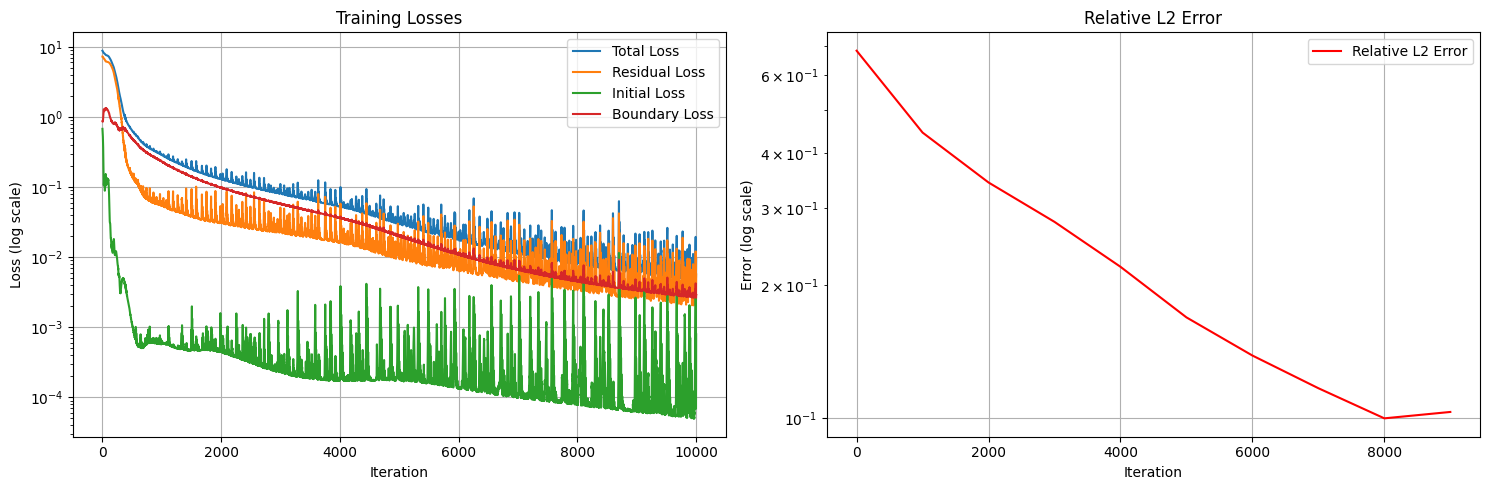

Loss: 9.38e-03 (R: 5.67e-03, I: 7.94e-04, B: 2.92e-03), Error: 1.03e-01: 100%|██████████| 10000/10000 [04:58<00:00, 33.52it/s]



Training completed! Best error: 9.99e-02


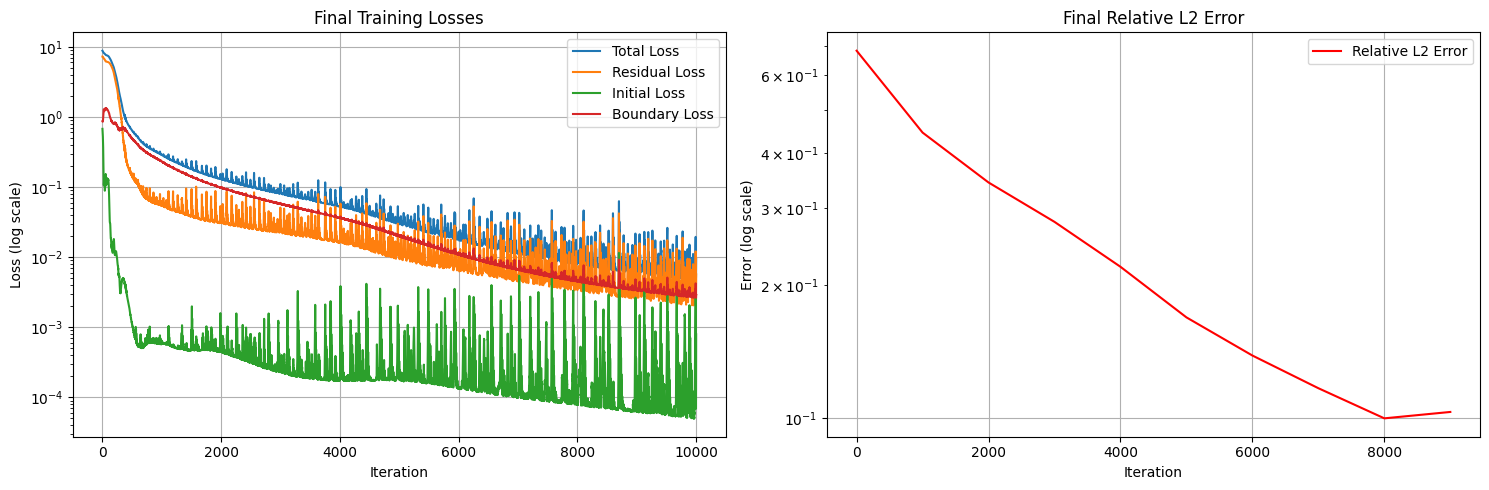

In [43]:
PARAMS = {
    'NC': 1000,        # количество точек коллокации
    'NI': 100,         # количество начальных точек
    'NB': 100,         # количество граничных точек
    'NC_TEST': 50,     # количество тестовых точек
    'SEED': 42,        # seed для воспроизводимости
    'LR': 1e-3,        # скорость обучения
    'EPOCHS': 10000,   # количество эпох
    'N_LAYERS': 3,     # количество слоев
    'FEATURES': 32,    # размер признаков
    'LOG_ITER': 1000   # частота логирования
}

main(**PARAMS)